### KNN을 이용한 인기 영화 분류하기
- movie_genere_final.csv 파일을 사용한다
- 컬럼은 아래와 같다
    - id : 영화에 할당된 고유 ID
    - original_title : 영화제목
    - target : 레이블(0~7) : 종속변수(target)-영화 인기정도의 범주값
    - vote_average : 영화 평점 평균
    - Action ~ TVMovie : 장르 포함 여부(yes=1/no=0)
    - director : 제작자
    - cast : 캐스팅배우들
    - keywords : 영화 키워드

1. 데이터 탐색
    - 중요 컬럼에 대한 분포등의 확인을 그래프를 통해 진행한다

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df=pd.read_csv('./data/movie_genre_final.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4775 entries, 0 to 4774
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4775 non-null   int64  
 1   original_title  4775 non-null   object 
 2   target          4775 non-null   int64  
 3   vote_average    4775 non-null   float64
 4   Action          4775 non-null   int64  
 5   Adventure       4775 non-null   int64  
 6   Fantasy         4775 non-null   int64  
 7   ScienceFiction  4775 non-null   int64  
 8   Crime           4775 non-null   int64  
 9   Drama           4775 non-null   int64  
 10  Thriller        4775 non-null   int64  
 11  Animation       4775 non-null   int64  
 12  Family          4775 non-null   int64  
 13  Western         4775 non-null   int64  
 14  Comedy          4775 non-null   int64  
 15  Romance         4775 non-null   int64  
 16  Horror          4775 non-null   int64  
 17  Mystery         4775 non-null   i

Text(0.5, 1.0, 'movie count')

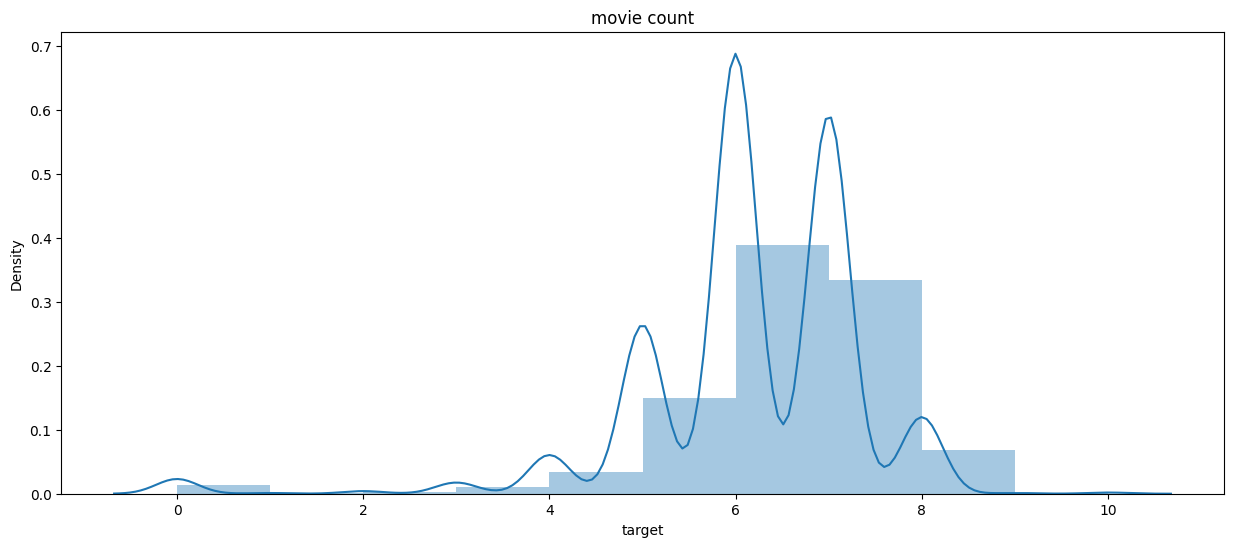

In [3]:
# 타겟데이터분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(1 , figsize = (15 , 6)) #그래프사이즈
sns.distplot(df['target'], bins=10)
plt.title('movie count')

#### 모델 분류에 사용할 컬럼을 선택한다
- 개봉하지 않은 영화에 대해 인기 분류를 진행할 예정이므로 기존 컬럼중 개봉해야 수집이 가능한 컬럼은 배제 시킨다

In [4]:
print(df.columns)

Index(['id', 'original_title', 'target', 'vote_average', 'Action', 'Adventure',
       'Fantasy', 'ScienceFiction', 'Crime', 'Drama', 'Thriller', 'Animation',
       'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery',
       'History', 'War', 'Music', 'Documentary', 'Foreign', 'TVMovie',
       'director', 'cast', 'keywords'],
      dtype='object')


In [10]:
# 장르별 영화 수 확인
count_list = []
genre_list = ['Action', 'Adventure',
       'Fantasy', 'ScienceFiction', 'Crime', 'Drama', 'Thriller', 'Animation',
       'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery',
       'History', 'War', 'Music', 'Documentary', 'Foreign', 'TVMovie']

In [11]:
for i in genre_list :
    count_list.append(df[df[i]==1])

In [12]:
pd.Series(count_list, index=genre_list)

Action                      id                            origin...
Adventure                   id                            origin...
Fantasy                     id                            origin...
ScienceFiction              id               original_title  tar...
Crime                       id         original_title  target  v...
Drama                       id             original_title  targe...
Thriller                    id                original_title  ta...
Animation                   id                                  ...
Family                      id                            origin...
Western                     id           original_title  target ...
Comedy                      id                original_title  ta...
Romance                     id                       original_ti...
Horror                      id                     original_titl...
Mystery                     id                             origi...
History                     id       original_ti

In [17]:
# plt.figure(1, figsize=(15,6))
# plt.barh(genre_list, count_list, color=sns.color_palette('hls',20))

In [21]:
temp = (df.Drama==1)&(df.vote_average >= 6.5)
drama = df[temp]
print('Drama 장르 중 평점 6.5점 이상인 영화 수 : ', len(drama))

Drama 장르 중 평점 6.5점 이상인 영화 수 :  1208


In [20]:
temp = (df.Thriller==1)&(df.vote_average >= 6.5)
Thrillerr = df[temp]
print('Thriller 장르 중 평점 6.5점 이상인 영화 수 : ', len(Thrillerr))

Thriller 장르 중 평점 6.5점 이상인 영화 수 :  415


In [22]:
temp = (df.Action==1)&(df.vote_average >= 6.5)
Actionn = df[temp]
print('Action 장르 중 평점 6.5점 이상인 영화 수 : ', len(Actionn))

Action 장르 중 평점 6.5점 이상인 영화 수 :  355


In [23]:
temp = (df.Comedy==1)&(df.vote_average >= 6.5)
Comedyy = df[temp]
print('Comedy 장르 중 평점 6.5점 이상인 영화 수 : ', len(Comedyy))

Comedy 장르 중 평점 6.5점 이상인 영화 수 :  521


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

2. 훈련 데이터와 테스트 데이터 나누기

In [25]:
x=df[genre_list]
y=df[['target']]

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(3820, 20)
(955, 20)


3. KNN을 이용한 분류
- 훈련데이터에 대하여 교차검증을 수행 후 평균 학습데이터 score를 확인한다
- 최적의 n(이웃수)을 찾기위해 여러번 모델을 구성해 가장 평가가 좋은 모델을 선택한다

In [27]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier()
scores = cross_val_score(knn, x_train, y_train, cv=5,scoring='accuracy')

for i in range(scores.size) :
    print(f"{i+1}번째 정확도 : {scores[i]}")

1번째 정확도 : 0.3481675392670157
2번째 정확도 : 0.3704188481675393
3번째 정확도 : 0.3887434554973822
4번째 정확도 : 0.3756544502617801
5번째 정확도 : 0.337696335078534


In [28]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors' : [1,3,5,7]}
grid_model = GridSearchCV(knn, param_grid=params,
                         scoring='accuracy', cv=5)

In [29]:
# 학습 진행 , .best_score_ 연결해서 확인
grid_model.fit(x_train, y_train).best_score_

0.3675392670157068

4. 영화가 액션이면서 스릴러 장르의 영화라면 인기 분류가 어떻게 되는지 확인해 보자

In [30]:
len(genre_list)

20

In [31]:
x_test.head()

,Action,Adventure,Fantasy,ScienceFiction,Crime,Drama,Thriller,Animation,Family,Western,Comedy,Romance,Horror,Mystery,History,War,Music,Documentary,Foreign,TVMovie
3088,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4246,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
1281,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1171,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3356,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [32]:
new_x = [1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
grid_model.predict([new_x])

array([6], dtype=int64)